# Amazon Fine Food Reviews Analysis

---



Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

E:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
final = final.sample(100000)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    84199
0    15801
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I have to be honest. I'm not entirely sure how water's PH impacts the body. I haven't really heard very much information on the subject. The Essentia Drinking water tasted good - it has a nice smooth taste and I like that it has added electrolytes. I'm a long-distance runner and so I drank some of this water following a workout. I can't say that I noticed a huge difference between the water that I usually drink and this one, but it wasn't bad. Good taste and the electrolytes (and zero calories) made this a good post-workout drink.
This reminds me of Mint chocolate chip ice cream without the calories. All these flavors has help me drink more water to loose more weight. I love these in the morning to jump start the day or whenever I need a little perk up during the day. They are a college student buddy during study time good as coffee but will not give you the jitters.
Previously I had been buying lunch meat and wrapping the pills in the meat. That got very expensive! This idea is genius

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I have to be honest. I'm not entirely sure how water's PH impacts the body. I haven't really heard very much information on the subject. The Essentia Drinking water tasted good - it has a nice smooth taste and I like that it has added electrolytes. I'm a long-distance runner and so I drank some of this water following a workout. I can't say that I noticed a huge difference between the water that I usually drink and this one, but it wasn't bad. Good taste and the electrolytes (and zero calories) made this a good post-workout drink.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I have to be honest. I'm not entirely sure how water's PH impacts the body. I haven't really heard very much information on the subject. The Essentia Drinking water tasted good - it has a nice smooth taste and I like that it has added electrolytes. I'm a long-distance runner and so I drank some of this water following a workout. I can't say that I noticed a huge difference between the water that I usually drink and this one, but it wasn't bad. Good taste and the electrolytes (and zero calories) made this a good post-workout drink.
This reminds me of Mint chocolate chip ice cream without the calories. All these flavors has help me drink more water to loose more weight. I love these in the morning to jump start the day or whenever I need a little perk up during the day. They are a college student buddy during study time good as coffee but will not give you the jitters.
Previously I had been buying lunch meat and wrapping the pills in the meat. That got very expensive! This idea is genius

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Previously I had been buying lunch meat and wrapping the pills in the meat. That got very expensive! This idea is genius! The dogs LOVE the taste. The pill fits in perfectly! And it came the very next day! Awesome!


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I have to be honest. I'm not entirely sure how water's PH impacts the body. I haven't really heard very much information on the subject. The Essentia Drinking water tasted good - it has a nice smooth taste and I like that it has added electrolytes. I'm a long-distance runner and so I drank some of this water following a workout. I can't say that I noticed a huge difference between the water that I usually drink and this one, but it wasn't bad. Good taste and the electrolytes (and zero calories) made this a good post-workout drink.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Previously I had been buying lunch meat and wrapping the pills in the meat That got very expensive This idea is genius The dogs LOVE the taste The pill fits in perfectly And it came the very next day Awesome 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:44<00:00, 2258.23it/s]


In [24]:
preprocessed_reviews[1500]

'previously buying lunch meat wrapping pills meat got expensive idea genius dogs love taste pill fits perfectly came next day awesome'

In [25]:
del filtered_data

# Applying Logistic Regression

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#here we are importing all the important libraries required for logistic regression

## Splitting the data

In [27]:
X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,final['Score'],test_size = 0.3)
#splitting the data into training and test in 7:3 ratio

print('size of training dataset is {} datapoints'.format(len(X_train)))
print('size of test dataset is {} datapoints'.format(len(X_test)))

size of training dataset is 70000 datapoints
size of test dataset is 30000 datapoints


# 1.Bag of Words 

In [28]:

vect = CountVectorizer()#initiating the vectorizer

vect.fit(X_train)#fitting training data into vectorizer makes it learn all the vocabalury

#transforming the data into training and test set
train_set = vect.transform(X_train)
test_set = vect.transform(X_test)

print('after vectoriztion')
print(train_set.shape)
print(test_set.shape)


after vectoriztion
(70000, 50636)
(30000, 50636)


In [29]:
print(train_set[10])#how the train dataset looks

  (0, 461)	1
  (0, 2167)	1
  (0, 3009)	1
  (0, 3117)	1
  (0, 3747)	1
  (0, 4106)	2
  (0, 4159)	1
  (0, 4407)	1
  (0, 4972)	1
  (0, 7211)	5
  (0, 7219)	1
  (0, 7281)	1
  (0, 8578)	2
  (0, 9055)	1
  (0, 12436)	2
  (0, 13256)	1
  (0, 13363)	1
  (0, 14807)	2
  (0, 15002)	2
  (0, 16274)	1
  (0, 16430)	1
  (0, 18267)	1
  (0, 18688)	1
  (0, 18793)	1
  (0, 18802)	1
  :	:
  (0, 33062)	1
  (0, 33330)	1
  (0, 34128)	1
  (0, 39390)	1
  (0, 39881)	1
  (0, 39923)	1
  (0, 40044)	1
  (0, 40546)	1
  (0, 41596)	1
  (0, 42110)	1
  (0, 42111)	1
  (0, 42178)	1
  (0, 42456)	1
  (0, 42671)	1
  (0, 42730)	1
  (0, 42902)	1
  (0, 43547)	2
  (0, 44084)	1
  (0, 45326)	1
  (0, 46286)	1
  (0, 46495)	1
  (0, 47080)	1
  (0, 47547)	1
  (0, 48924)	1
  (0, 49031)	1


# Standardizing the data

In [31]:
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

train_std = StandardScaler(with_mean=False).fit_transform(train_set)
test_std = StandardScaler(with_mean=False).fit_transform(test_set)
# standardizing the data for applying logistic Regression
print('After Standardizing')
print(train_std.shape)
print(test_std.shape)


After Standardizing
(70000, 50636)
(30000, 50636)


# L2 Regularization and GridSearch cross validation

In [32]:
param = {'C': [10**i for i in range(-4,5)]}
model = GridSearchCV(LogisticRegression(penalty='l2'),param_grid = param,scoring = 'roc_auc',n_jobs=-1)
#using GridSearchCv
model.fit(train_std,Y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [33]:
best_C_l2_bow = model.best_params_['C']
print(best_C_l2_bow)
#this gives us the best hyperparameter found after gridsearch cross validation


0.001


In [34]:
train_auc = model.cv_results_['mean_train_score']#deriving the avg training scores
cv_auc = model.cv_results_['mean_test_score']#deriving the average cross validation scores

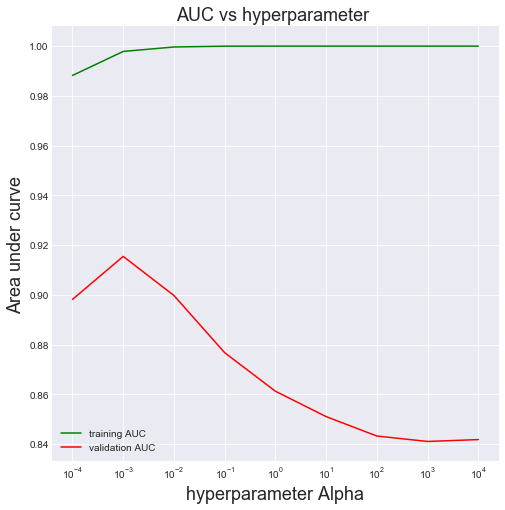

In [35]:
def error(t_auc,c_auc):
    val = [10**i for i in range(-4,5)]
    sns.set_style('darkgrid')
    plt.figure(figsize=(8,8))
    plt.plot(val,t_auc,'g',label = 'training AUC')#t_auc refers to the auc on training data
    plt.plot(val,c_auc,'r',label='validation AUC')# c_auc refers to the auc on cross validation data
#plotting the graph between AUC and hyperparameter for tuning 

    plt.xscale('log')#taking log scale for x axis for better analysing the results
    plt.xlabel('hyperparameter Alpha',fontsize=18)
    plt.ylabel('Area under curve',fontsize=18)
    #plt.xticks([])
    #plt.yticks([])
    plt.legend(loc = 'best')
    plt.title('AUC vs hyperparameter ',fontsize=18)
    
error(train_auc,cv_auc)#plotting the curve for bag of vectors l2 regularization

.This graph of hperparameter vs area under the curve tells us how model is fitting the data which helps us in determining where the model is overfitting and where its undergitting .we can clearly see a tradeoff at C = 0.001 hence we choose this value for our model

In [36]:
from sklearn.metrics import roc_auc_score
clf_optimal = LogisticRegression(C =0.001,penalty='l2')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
train_pred = clf_optimal.predict_proba(train_std)[:,1]
#predict_proba gives the probability of a data point belonging to a particular class

test_pred = clf_optimal.predict_proba(test_std)[:,1]
#this predicts the probability of data pointsin test dataset belonging to class '1'

test_auc_bow_l2 = roc_auc_score(Y_test,test_pred)
#calculating the area under the curve for the roc curve that will be drawn on test dataset






In [37]:
print('AUC on test dataset is {}'.format(test_auc_bow_l2))

AUC on test dataset is 0.9162694118173391


## ROC Curve

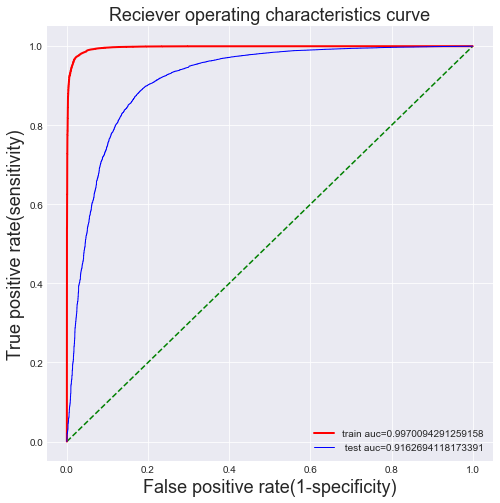

In [38]:
from sklearn.metrics import roc_curve

fpr_tr, tpr_tr, _ = roc_curve(Y_train,train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_pred)
#calculating the fpr,tpr and thresholds for each training and test dataset
auc_train = roc_auc_score(Y_train,train_pred)
auc_test = roc_auc_score(Y_test, test_pred)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")#this plots the roc curve for AUC = 0.5
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()
   

## F1 Score,Precision and Recall

In [39]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

pred = clf_optimal.predict(test_std)# predicting all the classes for test dataset for confusion matrix
pred_tr = clf_optimal.predict(train_std)#predicting all the classes for train dataset for confusin matrix


# calculating the precison score
print('precison score is {}'.format(precision_score(Y_test,pred)))

#calculating the recall score 
print('\nrecall_score is {}'.format(recall_score(Y_test,pred)))

#calculating the f1 score
print('\nf1 score is {}'.format(f1_score(Y_test,pred)))

precison score is 0.9285741293908572

recall_score is 0.9715551687304664

f1 score is 0.9495785322094192


## Confusion Matrix

In [40]:
train_matrix = pd.DataFrame(confusion_matrix(Y_train,pred_tr),range(2),range(2))# svaing the output to dataframe for train_data
print('training data')
print(train_matrix.head())


print('*****************************************')

print('test data')
test_matrix = pd.DataFrame(confusion_matrix(Y_test,pred),range(2),range(2))# svaing the output to dataframe for test_data
print(test_matrix.head())



training data
      0      1
0  9934   1144
1   201  58721
*****************************************
test data
      0      1
0  2834   1889
1   719  24558


so we need to visualize this dataframe in a heatmap for the Confusin Matrix

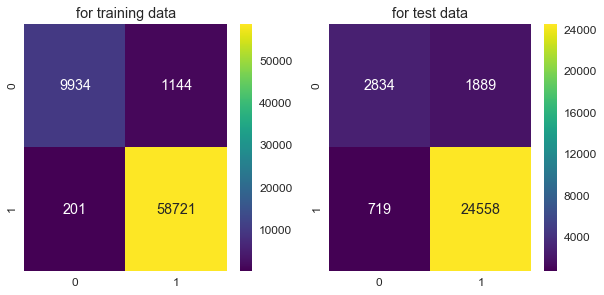

In [41]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,10))#setting the font size
plt.subplot(2,2,1)
plt.title('for training data')
sns.heatmap(train_matrix,annot = True,fmt = 'g',cmap = 'viridis')


#annot = True writes data values in each cell
# fmt is string formatting code which is to be used when adding annonations
# cmap is the mapping from data values to color space

plt.subplot(2,2,2)
plt.title('for test data')
sns.heatmap(test_matrix,annot = True,fmt = 'g',cmap = 'viridis')

## Most Important features

In [42]:
clf_optimal = LogisticRegression(C =best_C_l2_bow,penalty='l2')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
w = clf_optimal.coef_[0]#finding the coefficients of all features
print(w)


[0.00237672 0.00898837 0.00256652 ... 0.00145552 0.00557786 0.00255819]


In [43]:
features = vect.get_feature_names()#getting name of the features after fitting and transforming by countvectorizer
negative_indices = np.argsort(w)
positive_indices = np.argsort(w)[::-1]


print('TOP 20 important features for positive class and their coefficients in Bag of Words featurization using l2 regularization are:\n')
for i in (positive_indices[0:20]):
    print("%s\t --> \t%f"%(features[i],w[i]))
print("************************************************")

print('TOP 20 important features for negative class and their coefficients in Bag of Words featurization using l2 regularization are:\n')
for i in (negative_indices[0:20]):
    print("{} ---> {} ".format(features[i],w[i]))


TOP 20 important features for positive class and their coefficients in Bag of Words featurization using l2 regularization are:

great	 --> 	0.438527
love	 --> 	0.302308
best	 --> 	0.297170
good	 --> 	0.280709
delicious	 --> 	0.243617
excellent	 --> 	0.203756
perfect	 --> 	0.202239
loves	 --> 	0.196905
favorite	 --> 	0.180287
wonderful	 --> 	0.174039
nice	 --> 	0.173366
tasty	 --> 	0.146300
highly	 --> 	0.139235
easy	 --> 	0.138118
find	 --> 	0.136419
awesome	 --> 	0.127224
stores	 --> 	0.126735
pleased	 --> 	0.123507
amazing	 --> 	0.119508
smooth	 --> 	0.118069
************************************************
TOP 20 important features for negative class and their coefficients in Bag of Words featurization using l2 regularization are:

not ---> -0.31024603434674625 
disappointed ---> -0.19121383030359548 
worst ---> -0.17359327962272944 
terrible ---> -0.1504054346167949 
awful ---> -0.1494875515335521 
horrible ---> -0.13865347871387815 
disappointing ---> -0.13283802042188475 
waste -

## Pertubation testing

In [44]:
#importing the scipy library
import scipy as sp 

#weights before noise
W_before_noise = clf_optimal.coef_[0]
print(W_before_noise)

#taking a random small noise which follows the normal distribution
noise = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
print(noise)

#here adding the noise to all the elements f sparse matrix
train_std.data = train_std.data + noise

#training the model with new sparse matrix which has added noise to every element
lr = LogisticRegression(C = best_C_l2_bow,penalty = 'l2' )
lr.fit(train_std,Y_train)
#weights after adding noise
W_after_noise = lr.coef_[0]
print(W_after_noise)

#adding epsilon to every element of vector w for avoiding division from zero
epsilon = 0.000001
W_before_noise = W_before_noise + epsilon
W_after_noise  = W_after_noise  + epsilon



#finding the percentage change in weights before and after
delta = ((abs((W_before_noise-W_after_noise)/W_before_noise))*100)
print(delta)

sorted_delta = np.sort(delta) #sorting the percentage change for plotting frequency distribution
print(sorted_delta)

[0.00237672 0.00898837 0.00256652 ... 0.00145552 0.00557786 0.00255819]
-5.8824051715177196e-05
[0.00237793 0.00898788 0.0025667  ... 0.00145407 0.00557789 0.0025587 ]
[0.05083855 0.00546496 0.00710243 ... 0.09933708 0.00065248 0.02002303]
[8.43000604e-08 4.67146684e-07 9.30494403e-07 ... 1.60261676e+04
 1.74544314e+04 1.74544314e+04]


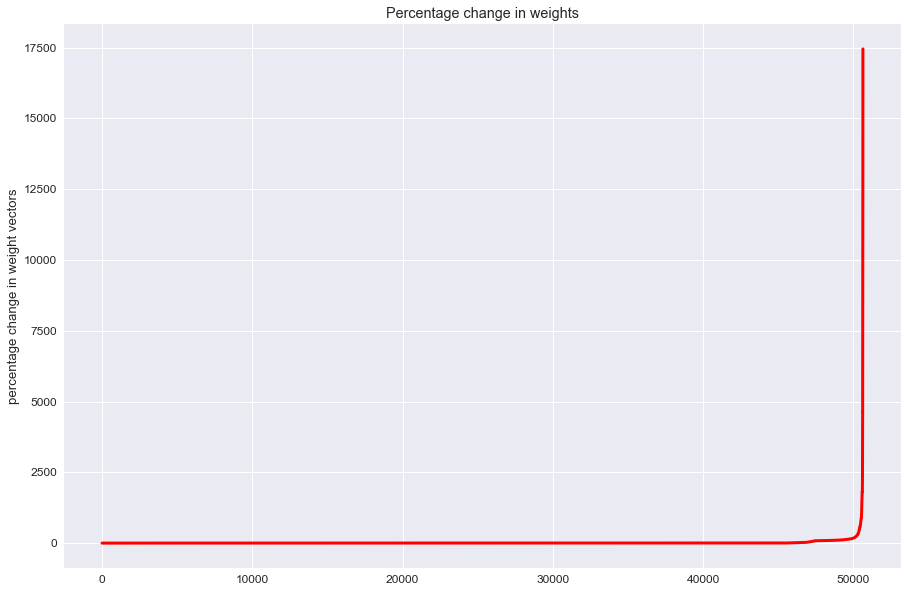

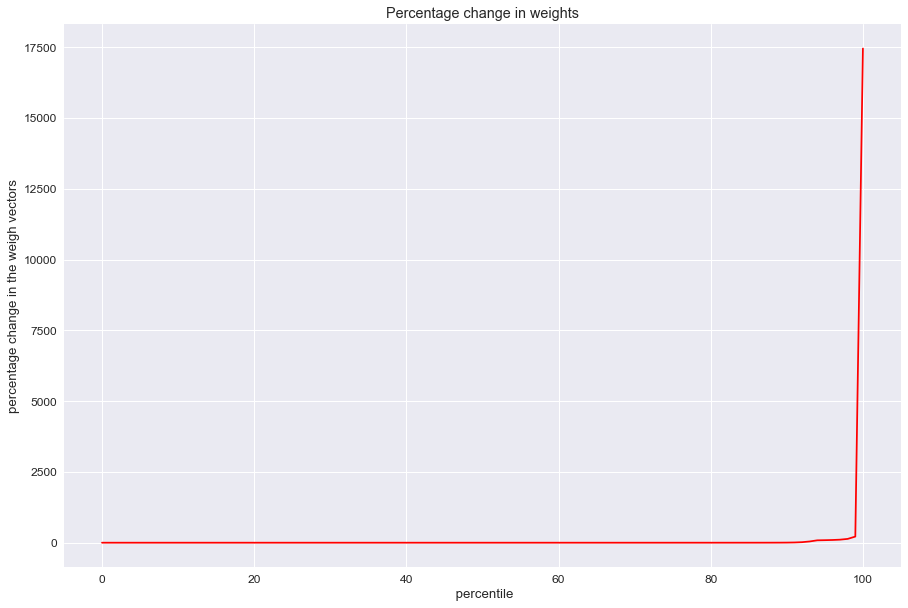

we can see that there is a steep rise in perentage change vector values in between 90th and 100th percentile,so we need to plot it for calculating the threshhold


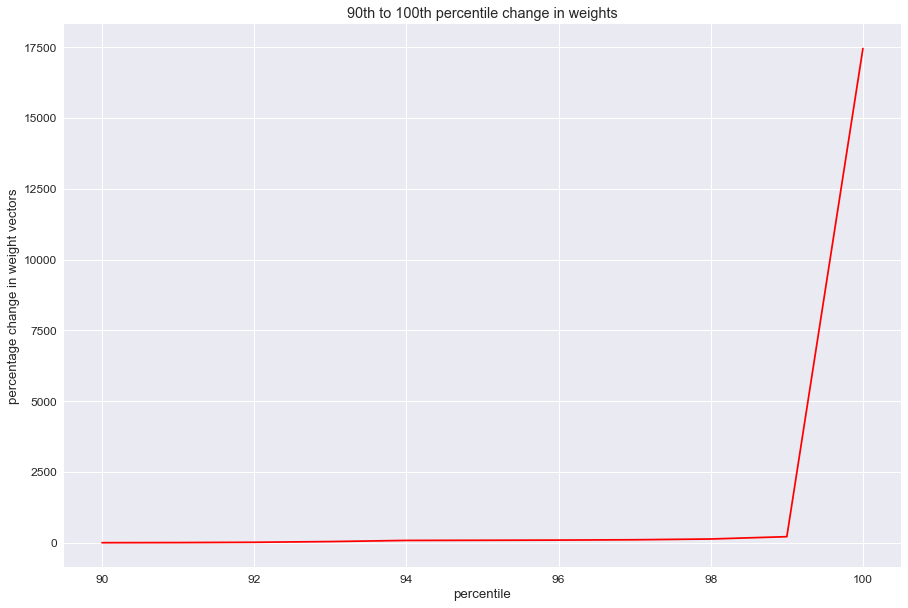

we can see that there is an abrupt change or rise in pecentage change values around 99th percentile,so we need to further plot 99th to 100th percentile for calculating the threshold


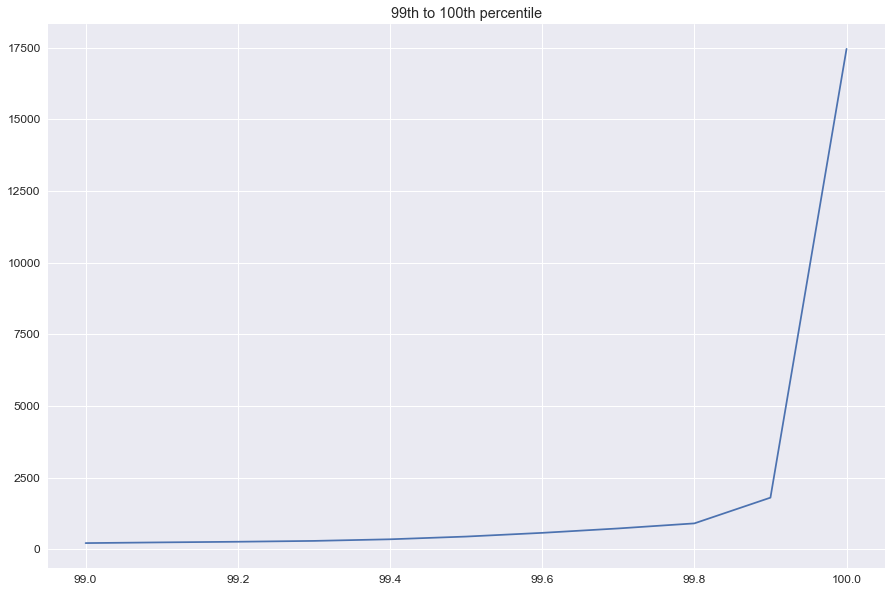

from the graph it is clear that there is a very steep increase in vaue at 99.8th percentile ,thats why we will choose value at 99.8th percentile as our threshold value


In [45]:
#elbow method
plt.figure(figsize = (15,10))
plt.plot(np.arange(0,len(delta)),sorted_delta,color = 'red',linestyle = '-',linewidth = 3)
plt.title('Percentage change in weights')
plt.ylabel('percentage change in weight vectors')
plt.show()


#plotting the percentiles
percentiles = []#list for storing the percentile values
for i in range(0,101,1):
    percentiles.append(np.percentile(sorted_delta,i))#calculating the percentile values
plt.figure(figsize = (15,10))
plt.plot(np.arange(0,101),percentiles,color = 'red',linestyle = '-')
plt.title('Percentage change in weights')
plt.xlabel(' percentile')
plt.ylabel('percentage change in the weigh vectors')
plt.show()

print('we can see that there is a steep rise in perentage change vector values in between 90th and 100th percentile,so we need to plot it for calculating the threshhold')


#plotting the percentiles from 90th to 100th
plt.figure(figsize=(15,10))
plt.plot(np.arange(90,101,1),percentiles[90:],color = 'red',linestyle = '-')
plt.title('90th to 100th percentile change in weights')
plt.xlabel('percentile')
plt.ylabel('percentage change in weight vectors')
plt.show()

print('we can see that there is an abrupt change or rise in pecentage change values around 99th percentile,so we need to further plot 99th to 100th percentile for calculating the threshold')


#plotting percentiles from 99th to 100th
percentiles = []
for i in np.arange(99.0,100.1,0.1):
    percentiles.append(np.percentile(delta,i))
plt.figure(figsize=(15,10))    
plt.plot(np.arange(99.0,100.1,0.1),percentiles)
plt.title('99th to 100th percentile')
plt.xlabel('')
plt.show()
print('from the graph it is clear that there is a very steep increase in vaue at 99.8th percentile ,thats why we will choose value at 99.8th percentile as our threshold value')

In [46]:
#calculating the threshold value at 99.8th percentile
threshold = np.percentile(sorted_delta,99.8)
print(threshold)

#storing the index of features whose pecentage change in weight vector is greater than the threshold
indices = []
feat = [] #for storing the features
for i in delta:
  if i>threshold:
    indices.append(list(delta).index(i))
    
for i in indices:
    feat.append(features[i])
    
print('features for which change in weight vector is greater than the threshold are:')
print(feat)

print(len(feat)/len(delta))#percentage of features whose weight vector value has considerable changed
print('AS number of features which have a considerable change in weight vectors are very less around {}%,so we can say that the features are not multicollinear and hence weight vectors can be used for feature importance'.format((len(feat)/len(delta))*100))

903.565043269974
features for which change in weight vector is greater than the threshold are:
['abovementioned', 'acetaia', 'ackee', 'afra', 'abovementioned', 'artsy', 'abovementioned', 'backlog', 'beacon', 'acetaia', 'bries', 'cappichino', 'cataract', 'cheeese', 'chimichanga', 'codfish', 'coleslaw', 'collusion', 'cornbreads', 'cradle', 'critiques', 'dazzled', 'artsy', 'drycleaned', 'eatbaby', 'eatbaby', 'erythorbate', 'abovementioned', 'fal', 'floraly', 'fruitea', 'funkier', 'geeze', 'acetaia', 'grimy', 'grittyness', 'gruyere', 'gvn', 'halifax', 'drycleaned', 'harmoniously', 'beacon', 'immobile', 'incubate', 'abovementioned', 'abovementioned', 'ladythis', 'linens', 'linstead', 'looose', 'beacon', 'lousinna', 'cappichino', 'acetaia', 'marriot', 'acetaia', 'acetaia', 'monrings', 'morel', 'mutation', 'acetaia', 'cheeese', 'grittyness', 'organicsyrups', 'eatbaby', 'funkier', 'morel', 'pepperiness', 'pescatora', 'pheonix', 'cappichino', 'chimichanga', 'abovementioned', 'rejuvenating', 'dr

# l1 regularization

In [ ]:
param = {'C': [10**i for i in range(-4,5)]}
model = GridSearchCV(LogisticRegression(penalty='l1'),param_grid = param,scoring = 'roc_auc',n_jobs=-1)
model.fit(train_std,Y_train)

In [0]:
best_C_l1_bow = model.best_params_['C']
print('best hyperparameter for l1 regularization in bag of words is:',best_C_l1_bow)

best hyperparameter for l1 regularization in bag of words is: 0.01


In [0]:
train_auc = model.cv_results_['mean_train_score']#deriving the avg training scores
cv_auc = model.cv_results_['mean_test_score']#deriving the average cross validation scores

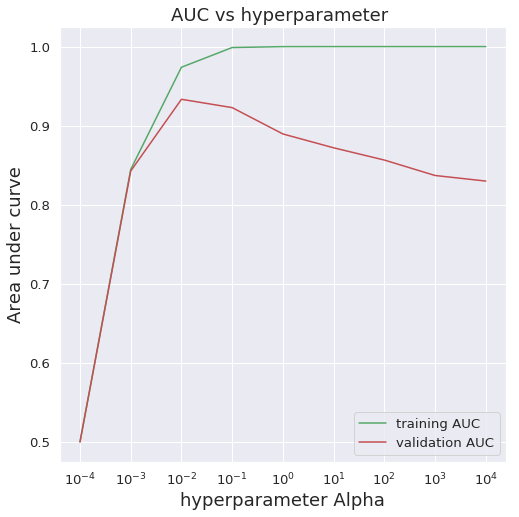

In [0]:
error(train_auc,cv_auc)#plotting the AUC vs Hyperparameter 

In [0]:
from sklearn.metrics import roc_auc_score
clf_optimal = LogisticRegression(C =best_C_l1_bow,penalty='l1')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
train_pred = clf_optimal.predict_proba(train_std)[:,1]
#predict_proba gives the probability of a data point belonging to a particular class

test_pred = clf_optimal.predict_proba(test_std)[:,1]
#this predicts the probability of data pointsin test dataset belonging to class '1'

test_auc_bow_l1 = roc_auc_score(Y_test,test_pred)
print('AUC on test dataset is{}'.format(test_auc_bow_l1))
#calculating the area under the curve for the roc curve that will be drawn on test dataset


AUC on test dataset is0.9390694969395107


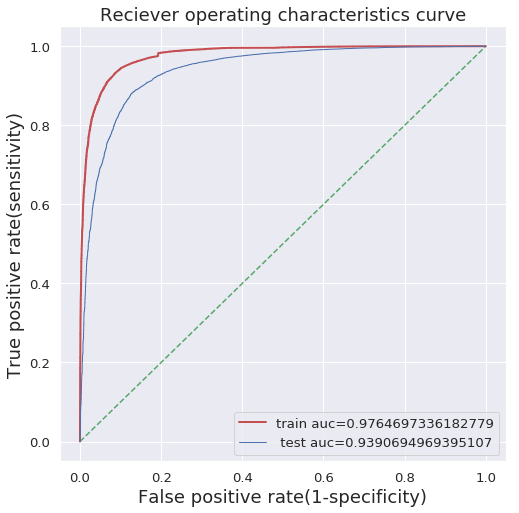

In [0]:
from sklearn.metrics import roc_curve

fpr_tr, tpr_tr, _ = roc_curve(Y_train,train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_pred)
#calculating the fpr,tpr and thresholds for each training and test dataset
auc_train = roc_auc_score(Y_train,train_pred)
auc_test = roc_auc_score(Y_test, test_pred)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()
   

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

pred = clf_optimal.predict(test_std)# predicting all the classes for test dataset for confusion matrix
pred_tr = clf_optimal.predict(train_std)#predicting all the classes for train dataset for confusin matrix


# calculating the precison score
print('precison score is {}'.format(precision_score(Y_test,pred)))

#calculating the recall score 
print('\nrecall_score is {}'.format(recall_score(Y_test,pred)))

#calculating the f1 score
print('\nf1 score is {}'.format(f1_score(Y_test,pred)))

precison score is 0.9215986839645568

recall_score is 0.9791848732819576

f1 score is 0.9495194622599719


In [0]:
train_matrix = pd.DataFrame(confusion_matrix(Y_train,pred_tr),range(2),range(2))
print(train_matrix)

print('***********************************')

test_matrix = pd.DataFrame(confusion_matrix(Y_test,pred),range(2),range(2))# svaing the output to dataframe to visualize a heatmap
print(test_matrix.head())

      0      1
0  7853   3081
1   527  58539
***********************************
      0      1
0  2729   2097
1   524  24650


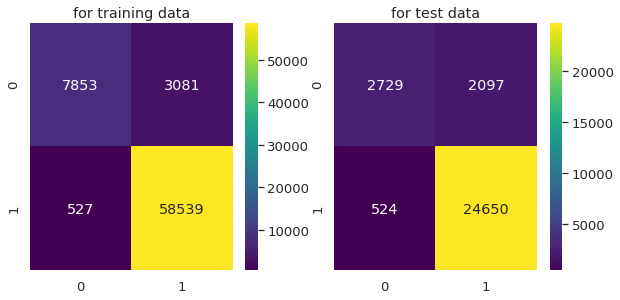

In [0]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,10))#setting the font size
plt.subplot(2,2,1)
plt.title('for training data')
sns.heatmap(train_matrix,annot = True,fmt = 'g',cmap = 'viridis')


#annot = True writes data values in each cell
# fmt is string formatting code which is to be used when adding annonations
# cmap is the mapping from data values to color space

plt.subplot(2,2,2)
plt.title('for test data')
sns.heatmap(test_matrix,annot = True,fmt = 'g',cmap = 'viridis')

## Most important features

In [0]:
clf_optimal = LogisticRegression(C =best_C_l1_bow,penalty='l1')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
w = clf_optimal.coef_[0]#finding the coefficients of all features
print(w)


[ 0.          0.         -0.01062846 ...  0.          0.
  0.        ]


In [0]:
features = vect.get_feature_names()#getting name of the features after fitting and transforming by countvectorizer
negative_indices = np.argsort(w)
positive_indices = np.argsort(w)[::-1]


print('TOP 20 important features for positive class and their coefficients in Bag of Words featurization using l2 regularization are:\n')
for i in (positive_indices[0:20]):
    print("%s\t --> \t%f"%(features[i],w[i]))
print("************************************************")

print('TOP 20 important features for negative class and their coefficients in Bag of Words featurization using l2 regularization are:\n')
for i in (negative_indices[0:20]):
    print("{} ---> {} ".format(features[i],w[i]))


TOP 20 important features for positive class and their coefficients in Bag of Words featurization using l2 regularization are:

great	 --> 	0.665626
best	 --> 	0.467307
delicious	 --> 	0.419023
love	 --> 	0.357422
good	 --> 	0.348398
perfect	 --> 	0.334929
loves	 --> 	0.274010
excellent	 --> 	0.261527
nice	 --> 	0.244055
highly	 --> 	0.230971
wonderful	 --> 	0.222770
amazing	 --> 	0.217440
favorite	 --> 	0.201767
happy	 --> 	0.195210
tasty	 --> 	0.181755
find	 --> 	0.169823
thank	 --> 	0.159034
yummy	 --> 	0.158329
awesome	 --> 	0.148319
works	 --> 	0.143094
************************************************
TOP 20 important features for negative class and their coefficients in Bag of Words featurization using l2 regularization are:

not ---> -0.50361894119312 
disappointed ---> -0.2403346898970079 
worst ---> -0.20667290722671394 
awful ---> -0.18977914885902306 
terrible ---> -0.1835300525493563 
disappointing ---> -0.16933446163413673 
horrible ---> -0.1679227752774337 
money ---> -0.

## Sparsity after l1 regularization

This is being to done to see how l1 regularization creates sparsity and reducing feature importance also

#### C = 0.01

In [0]:
clf = LogisticRegression(C = 0.01,penalty = 'l1')#fitting the model with the best hyperparameter 
clf.fit(train_std,Y_train)
w = clf.coef_
#this counts the number of non zero coefficients

print('After Regularization:')
print('\nnumber of non-zero elements in W are: {}'.format(np.count_nonzero(w)))



After Regularization:

number of non-zero elements in W are: 4885


#### C = 0.1

In [0]:
clf = LogisticRegression(C = 0.1,penalty = 'l1')#fitting the model with the best hyperparameter 
clf.fit(train_std,Y_train)
w = clf.coef_
#this counts the number of non zero coefficients

print('After Regularization:')
print('\nnumber of non-zero elements in W are: {}'.format(np.count_nonzero(w)))


After Regularization:

number of non-zero elements in W are: 12799


#### C = 1.0

In [0]:
clf = LogisticRegression(C = 1,penalty = 'l1')#fitting the model with the best hyperparameter 
clf.fit(train_std,Y_train)
w = clf.coef_
#this counts the number of non zero coefficients

print('After Regularization:')
print('\nnumber of non-zero elements in W are: {}'.format(np.count_nonzero(w)))


After Regularization:

number of non-zero elements in W are: 14826


#### C = 10

In [0]:
clf = LogisticRegression(C = 10,penalty = 'l1')#fitting the model with the best hyperparameter 
clf.fit(train_std,Y_train)
w = clf.coef_
#this counts the number of non zero coefficients

print('After Regularization:')
print('\nnumber of non-zero elements in W are: {}'.format(np.count_nonzero(w)))


After Regularization:

number of non-zero elements in W are: 15476


this shows that as we decrease 'C' which means increasing 'lambda' l1 regularization creates more and more sparsity which is making the coefficient of features zero and thus helping in determining the feature importance

# TFIDF

In [30]:
vect = TfidfVectorizer(ngram_range = (1,2),min_df = 10)#this ensures that  word which is occuring less than 10 times gets discarded

vect.fit(X_train)#vectorizer reading and forming all the vocabalury from training dataset

train_set = vect.transform(X_train)
test_set = vect.transform(X_test)
#transforming the data after learning the vocabalury this creates sparse matrices

print('After Vectorization:')
print('\nsize of training dataset is {}'.format(train_set.shape))
print("size of test dataset is {}".format(test_set.shape))

After Vectorization:

size of training dataset is (70000, 41055)
size of test dataset is (30000, 41055)


In [33]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
train_std = StandardScaler(with_mean = False).fit_transform(train_set)
test_std = StandardScaler(with_mean = False).fit_transform(test_set)
#with_mean cannot be True here because we are dealing with sparse matrices
print('after standardization: {}'.format(train_std.shape))

after standardization: (70000, 41055)


## L2 regularization

In [34]:
param = {'C': [10**i for i in range(-4,5)]}#fixing the size and range of parameters to  be searched

model = GridSearchCV(LogisticRegression(penalty='l2'),param_grid = param,scoring = 'roc_auc',n_jobs=-1)#using gridsearch cross validation
model.fit(train_std,Y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [39]:
train_auc = model.cv_results_['mean_train_score']# the avg training roc auc scores
cv_auc = model.cv_results_['mean_test_score']# the average cross roc auc validation scores

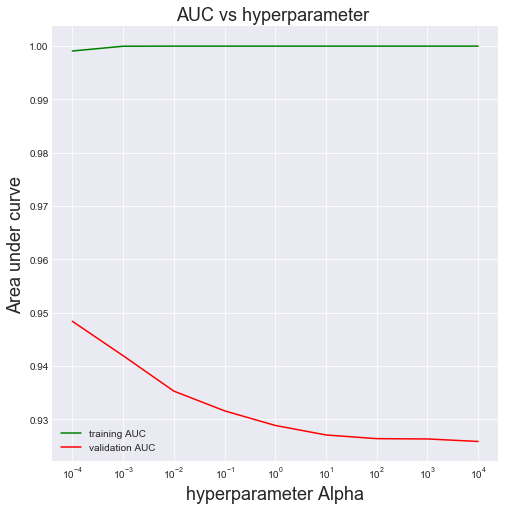

In [40]:
error(train_auc,cv_auc)#plotting the auc vs hyperparameter curve

clearly we can see the Training AUC and cv AUC doing tradeoff at C = 0.0001

In [35]:
best_C_tfidf_l2 = model.best_params_['C']
print(best_C_tfidf_l2)

0.0001


thus we get best hyperparameter here as C = 0.0001

In [41]:
from sklearn.metrics import roc_auc_score
clf_optimal = LogisticRegression(C =0.0001,penalty='l2')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
train_pred = clf_optimal.predict_proba(train_std)[:,1]
#predict_proba gives the probability of a data point belonging to a particular class

test_pred = clf_optimal.predict_proba(test_std)[:,1]
#this predicts the probability of data pointsin test dataset belonging to class '1'

test_auc_tfidf_l2 = roc_auc_score(Y_test,test_pred)
print('AUC on test dataset is{}'.format(test_auc_tfidf_l2))
#calculating the area under the curve for the roc curve that will be drawn on test dataset


AUC on test dataset is0.954694837516176


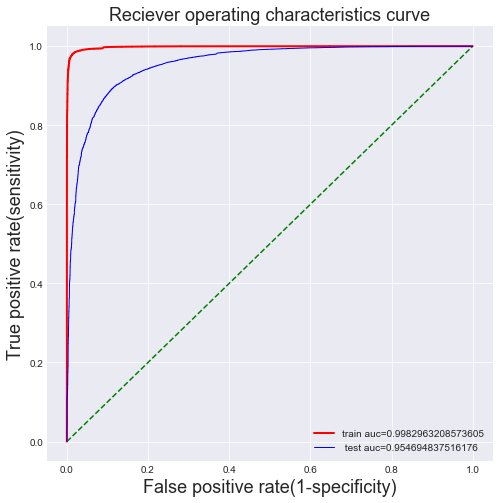

In [42]:
from sklearn.metrics import roc_curve

fpr_tr, tpr_tr, _ = roc_curve(Y_train,train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_pred)
#calculating the fpr,tpr and thresholds for each training and test dataset
auc_train = roc_auc_score(Y_train,train_pred)
auc_test = roc_auc_score(Y_test, test_pred)
#calculating the area under the curve for both test and train auc after fitting the model with optimal parameters
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()
   

In [45]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


pred = clf_optimal.predict(test_std)
pred_tr = clf_optimal.predict(train_std)


# predicting all the classes for test dataset for confusion matrix

# calculating the precison score
print('precison score is {}'.format(precision_score(Y_test,pred)))

#calculating the recall score 
print('\nrecall_score is {}'.format(recall_score(Y_test,pred)))

#calculating the f1 score
print('\nf1 score is {}'.format(f1_score(Y_test,pred)))

precison score is 0.9294692476968408

recall_score is 0.9855255872814996

f1 score is 0.9566769679636065


In [47]:
test_matrix = pd.DataFrame(confusion_matrix(Y_test,pred),range(2),range(2))# svaing the output to dataframe to visualize a heatmap
print(test_matrix.head())

print("****************************************")

train_matrix = pd.DataFrame(confusion_matrix(Y_train,pred_tr),range(2),range(2))#confusion matrix for trainig data
print(train_matrix.head())

      0      1
0  2823   1891
1   366  24920
****************************************
      0      1
0  9731   1222
1   116  58931


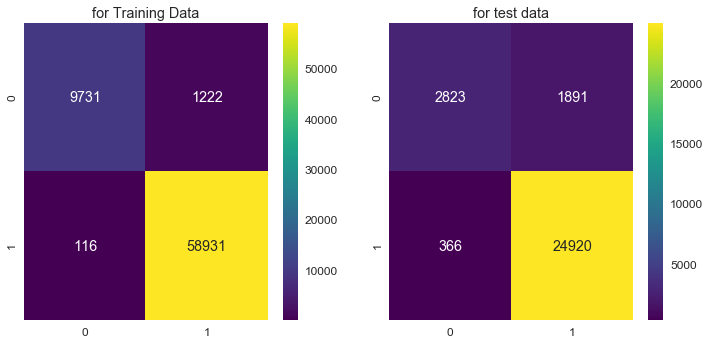

In [53]:
sns.set(font_scale = 1.2)
plt.figure(figsize = (12,12))#setting the font size
plt.subplot(2,2,1)
plt.title('for Training Data')
sns.heatmap(train_matrix,annot = True,fmt = 'g',cmap = 'viridis')#heatmap for training data confusion matrix 

plt.subplot(2,2,2)
plt.title('for test data')
sns.heatmap(test_matrix,annot = True,fmt = 'g',cmap = 'viridis')
#annot = True writes data values in each cell
# fmt is string formatting code which is to be used when adding annonations
# cmap is the mapping from data values to color space

## Most important Features

In [55]:
clf_optimal = LogisticRegression(C =best_C_tfidf_l2,penalty='l2')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
w = clf_optimal.coef_[0]#finding the coefficients of all features
print(w)



[ 0.00032754  0.00142451 -0.00222142 ...  0.00259823 -0.00295761
 -0.00301293]


In [56]:
features = vect.get_feature_names()#getting name of the features after fitting and transforming by countvectorizer

#sorting the indexes with respect to values
negative_indices = np.argsort(w)

#reversing the sorted indexes with respect to values for positive indexes
positive_indices = np.argsort(w)[::-1]


print('TOP 20 important features for positive class and their coefficients in Bag of Words featurization using l2 regularization are:\n')
for i in (positive_indices[0:20]):
    print("%s\t --> \t%f"%(features[i],w[i]))
print("************************************************")

print('TOP 20 important features for negative class and their coefficients in Bag of Words featurization using l2 regularization are:\n')
for i in (negative_indices[0:20]):
    print("{} ---> {} ".format(features[i],w[i]))



TOP 20 important features for positive class and their coefficients in Bag of Words featurization using l2 regularization are:

great	 --> 	0.113833
good	 --> 	0.085018
love	 --> 	0.083415
best	 --> 	0.080686
delicious	 --> 	0.071410
perfect	 --> 	0.056889
excellent	 --> 	0.055816
loves	 --> 	0.055595
favorite	 --> 	0.048871
tasty	 --> 	0.048011
nice	 --> 	0.047931
wonderful	 --> 	0.046754
happy	 --> 	0.045685
easy	 --> 	0.044156
highly	 --> 	0.042154
find	 --> 	0.041509
use	 --> 	0.041445
little	 --> 	0.040577
loved	 --> 	0.039478
awesome	 --> 	0.038515
************************************************
TOP 20 important features for negative class and their coefficients in Bag of Words featurization using l2 regularization are:

disappointed ---> -0.06224299588720672 
not buy ---> -0.059962535218251685 
worst ---> -0.05695553218008697 
not recommend ---> -0.055773149494665324 
not worth ---> -0.05517043646370065 
awful ---> -0.04973004114386868 
disappointing ---> -0.049558474967031425 

## L1 regularization

In [57]:
param = {'C': [10**i for i in range(-4,5)]}#fixing the size and range of parameters to  be searched

model = GridSearchCV(LogisticRegression(penalty='l1'),param_grid = param,scoring = 'roc_auc',n_jobs=-1)#using gridsearch cross validation
model.fit(train_std,Y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [100]:
train_auc = model.cv_results_['mean_train_score']#deriving the avg training scores
cv_auc = model.cv_results_['mean_test_score']#deriving the average cross validation scores

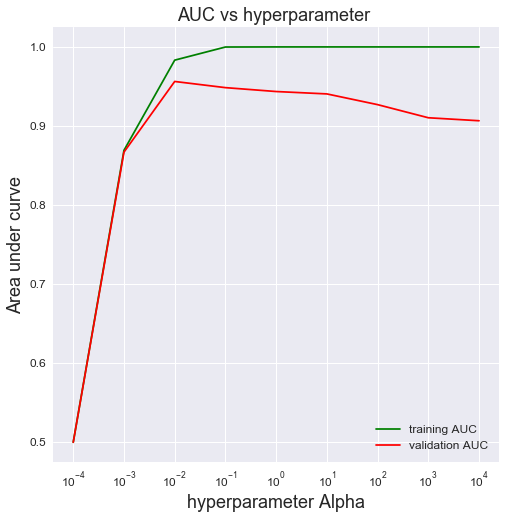

In [59]:
error(train_auc,cv_auc)

After using l1 regularization we can clearly see the tradeoff between bias and variance happening at C = 0.01 from where we can definitely deduce that 
as l1 regularization creates sparsity thats why optimal value of hyperparameter 'lambda' decreases.

In [60]:
best_C_tfidf_l1 = model.best_params_["C"]
print(best_C_tfidf_l1)

0.01


In [65]:
from sklearn.metrics import roc_auc_score
clf_optimal = LogisticRegression(C =best_C_tfidf_l1,penalty='l1')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
train_pred = clf_optimal.predict_proba(train_std)[:,1]
#predict_proba gives the probability of a data point belonging to a particular class

test_pred = clf_optimal.predict_proba(test_std)[:,1]
#this predicts the probability of data pointsin test dataset belonging to class '1'

test_auc_tfidf_l1 = roc_auc_score(Y_test,test_pred)
print('AUC on test dataset is{}'.format(test_auc_tfidf_l1))
#calculating the area under the curve for the roc curve that will be drawn on test dataset


AUC on test dataset is0.9609490424872511


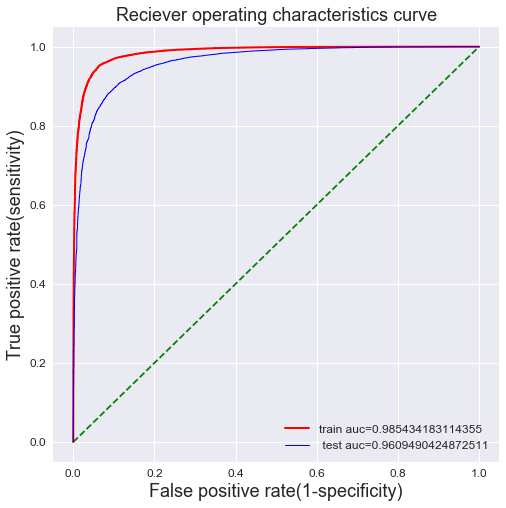

In [66]:
fpr_tr, tpr_tr, _ = roc_curve(Y_train,train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_pred)
#calculating the fpr,tpr and thresholds for each training and test dataset
auc_train = roc_auc_score(Y_train,train_pred)
auc_test = roc_auc_score(Y_test, test_pred)
#calculating the area under the curve for both test and train auc after fitting the model with optimal parameters

sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")
#This signifies the Area under curve = 0.5
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()

In [68]:
pred = clf_optimal.predict(test_std)
# predicting all the classes for test dataset for confusion matrix

#predicting all the values for class labels on training dataset
pred_tr = clf_optimal.predict(train_std)

# calculating the precison score
print('precison score is {}'.format(precision_score(Y_test,pred)))

#calculating the recall score 
print('\nrecall_score is {}'.format(recall_score(Y_test,pred)))

#calculating the f1 score
print('\nf1 score is {}'.format(f1_score(Y_test,pred)))

precison score is 0.9384417354433255

recall_score is 0.9803053072846635

f1 score is 0.9589168278529981


In [69]:
test_matrix = pd.DataFrame(confusion_matrix(Y_test,pred),range(2),range(2))# svaing the output to dataframe to visualize a heatmap
print(test_matrix.head())

print("****************************************")

train_matrix = pd.DataFrame(confusion_matrix(Y_train,pred_tr),range(2),range(2))#confusion matrix for trainig data
print(train_matrix.head())

      0      1
0  3088   1626
1   498  24788
****************************************
      0      1
0  8374   2579
1   540  58507


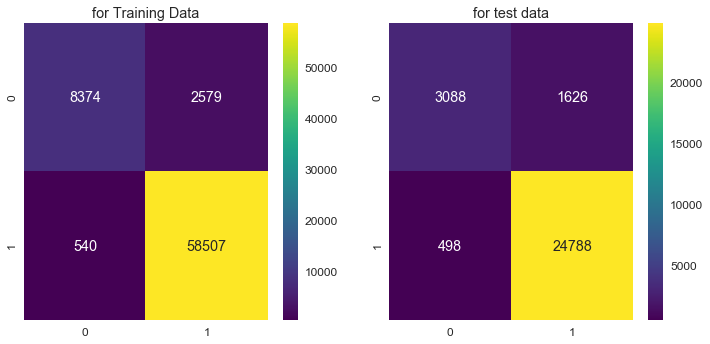

In [70]:
sns.set(font_scale = 1.2)
plt.figure(figsize = (12,12))#setting the font size
plt.subplot(2,2,1)
plt.title('for Training Data')
sns.heatmap(train_matrix,annot = True,fmt = 'g',cmap = 'viridis')#heatmap for training data confusion matrix 

plt.subplot(2,2,2)
plt.title('for test data')
sns.heatmap(test_matrix,annot = True,fmt = 'g',cmap = 'viridis')
#annot = True writes data values in each cell
# fmt is string formatting code which is to be used when adding annonations
# cmap is the mapping from data values to color space

## Most Important Features

In [72]:
clf_optimal = LogisticRegression(C =best_C_tfidf_l1,penalty='l1')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
w = clf_optimal.coef_[0]#finding the coefficients of all features
print(w)



features = vect.get_feature_names()#getting name of the features after fitting and transforming by countvectorizer

#sorting the indexes with respect to values
negative_indices = np.argsort(w)

#reversing the sorted indexes with respect to values for positive indexes
positive_indices = np.argsort(w)[::-1]


print('TOP 20 important features for positive class and their coefficients in Bag of Words featurization using l1 regularization are:\n')
for i in (positive_indices[0:20]):
    print("%s\t --> \t%f"%(features[i],w[i]))
print("************************************************")

print('TOP 20 important features for negative class and their coefficients in Bag of Words featurization using l1 regularization are:\n')
for i in (negative_indices[0:20]):
    print("{} ---> {} ".format(features[i],w[i]))



[0. 0. 0. ... 0. 0. 0.]
TOP 20 important features for positive class and their coefficients in Bag of Words featurization using l1 regularization are:

great	 --> 	0.682281
best	 --> 	0.433707
good	 --> 	0.424674
delicious	 --> 	0.389063
perfect	 --> 	0.322125
love	 --> 	0.312741
excellent	 --> 	0.304821
loves	 --> 	0.263042
not disappointed	 --> 	0.248037
happy	 --> 	0.238137
favorite	 --> 	0.206476
tasty	 --> 	0.196615
wonderful	 --> 	0.193660
nice	 --> 	0.190582
definitely	 --> 	0.181934
awesome	 --> 	0.177287
easy	 --> 	0.168317
highly	 --> 	0.156395
pleased	 --> 	0.153040
yummy	 --> 	0.134047
************************************************
TOP 20 important features for negative class and their coefficients in Bag of Words featurization using l1 regularization are:

disappointed ---> -0.2981350031552851 
not ---> -0.21638009311590178 
worst ---> -0.19110919901648568 
not worth ---> -0.17228516771546237 
not recommend ---> -0.17075745761780933 
awful ---> -0.16445842408829742 
not 

# WORD TO VEC

In [73]:
s_train = []
for sent in X_train:
    s_train.append(sent.split())
#preparing the training data for  word to vector vectorization    
    
s_test = []
for sent in X_test:
    s_test.append(sent.split())
#preparing the test data for word to vector fatorization

In [74]:
# this line of code trains the w2v model on the give list of sentances   

w2v_model=Word2Vec(s_train,min_count=5,size=50, workers=4)# min_count = 5 considers only words that occured atleast 5 times

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


number of words that occured minimum 5 times  16065


In [75]:
print('sample words :',w2v_words[0:50])

sample words : ['received', 'sample', 'pack', 'raisin', 'variety', 'quaker', 'soft', 'baked', 'oatmeal', 'cookies', 'influenster', 'test', 'family', 'month', 'old', 'son', 'loved', 'cookie', 'almost', 'ate', 'whole', 'thing', 'manage', 'couple', 'bites', 'love', 'chewy', 'ness', 'plus', 'provides', 'good', 'source', 'fiber', 'something', 'not', 'incorporate', 'enough', 'diets', 'sometimes', 'definitely', 'consider', 'purchasing', 'snack', 'big', 'bag', 'full', 'really', 'individually', 'wrapped', 'keep']


## Average W2V

In [77]:
#computing average word to vector for training data 

train_set = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(s_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_set.append(sent_vec)

print(len(train_set))#number of datapoints in training set

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:47<00:00, 417.79it/s]


70000


In [78]:
#computing average word to vector for test data 

test_set = [] # the avg-w2v for each sentence/review is stored in this list
for sent in s_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_set.append(sent_vec)

print(len(test_set))#number of datapoints in test set

30000


In [79]:
print(train_set[0])

[-0.01944027 -0.23175346 -0.07724504 -1.00644308 -0.96338314  0.45008989
 -0.23809615 -0.44930338 -0.94600899 -0.05514701  0.52156017 -0.10737156
 -0.59551718  0.48332506  0.30648719  0.28435665  0.00300338 -0.52443471
  0.42232519 -0.13700283  0.09899347 -0.10644326 -0.14390756 -0.89639726
  0.92507419 -0.08738389 -0.50632386  0.02995053  0.54368011 -0.45232807
 -1.19497342 -0.25348351 -0.4113364  -0.15183082  0.01128826  0.26426542
  0.120862    0.17180756 -0.41578801  0.79236498  0.48269884  0.85827908
 -0.14849857  0.24639349  0.45514648 -0.07611567 -0.12905833 -0.35698361
  0.31028208  1.07123898]


In [80]:
print(len(test_set[0]))

50


## Standardizing the data

In [81]:
#Standardizing the data
train_std = StandardScaler(with_mean = False).fit_transform(train_set)
test_std = StandardScaler(with_mean = False).fit_transform(test_set)
#with_mean cannot be True here because we are dealing with sparse matrices
print('after standardization: {}'.format(train_std.shape))
print("test data:",test_std.shape)

after standardization: (70000, 50)
test data: (30000, 50)


## L2 regularization and Grid Searchcv

In [86]:
param = {'C': [10**i for i in range(-4,5)]}#fixing the size and range of parameters to  be searched

model = GridSearchCV(LogisticRegression(penalty='l2'),param_grid = param,scoring = 'roc_auc',n_jobs=-1)#using gridsearch cross validation
model.fit(train_std,Y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [87]:
train_auc = model.cv_results_['mean_train_score']#deriving the avg training scores
cv_auc = model.cv_results_['mean_test_score']#deriving the average cross validation scores

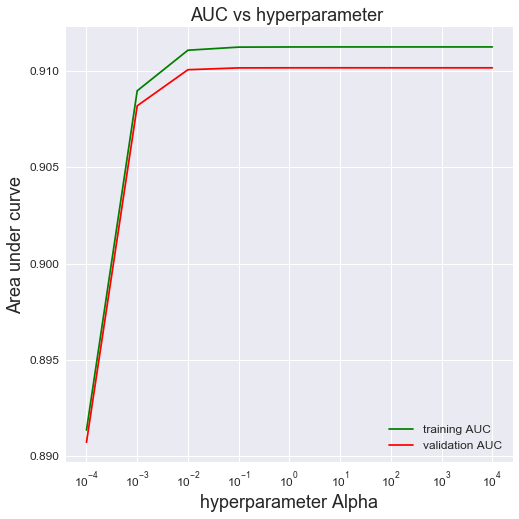

In [88]:
error(train_auc,cv_auc)#plotting the results

we see here best hyperparameter after tuning the model is c = 10

In [90]:
best_C_l2_aW2v = model.best_params_["C"]
print(best_C_l2_aW2v)
#this gives us the best hyperparameter found after gridsearch cross validation


10


In [91]:
from sklearn.metrics import roc_auc_score
clf_optimal = LogisticRegression(C =best_C_l2_aW2v,penalty='l2')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
train_pred = clf_optimal.predict_proba(train_std)[:,1]
#predict_proba gives the probability of a data point belonging to a particular class

test_pred = clf_optimal.predict_proba(test_std)[:,1]
#this predicts the probability of data pointsin test dataset belonging to class '1'

test_auc_aW2v_l2 = roc_auc_score(Y_test,test_pred)
print('AUC on test dataset is {}'.format(test_auc_aW2v_l2))
#calculating the area under the curve for the roc curve that will be drawn on test dataset


AUC on test dataset is 0.9081629703078412


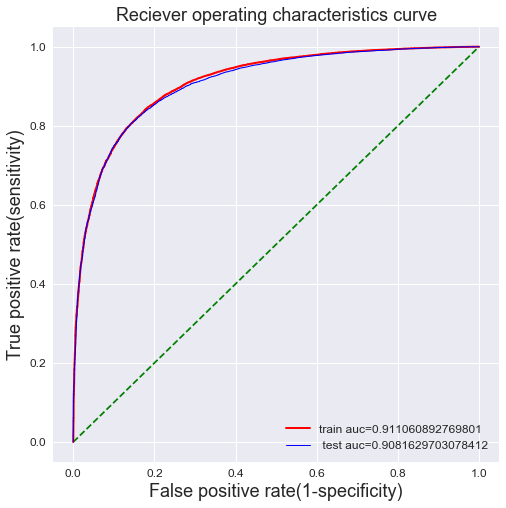

In [92]:
from sklearn.metrics import roc_curve

fpr_tr, tpr_tr, _ = roc_curve(Y_train,train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_pred)
#calculating the fpr,tpr and thresholds for each training and test dataset
auc_train = roc_auc_score(Y_train,train_pred)
auc_test = roc_auc_score(Y_test, test_pred)
#calculating the area under the curve for both test and train auc after fitting the model with optimal parameters
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()
   

In [94]:
pred = clf_optimal.predict(test_std)
# predicting all the classes for test dataset for confusion matrix

#predicting all the classes for training dataset for confusion matrix
pred_tr = clf_optimal.predict(train_std)

# calculating the precison score
print('precison score is {}'.format(precision_score(Y_test,pred)))

#calculating the recall score 
print('\nrecall_score is {}'.format(recall_score(Y_test,pred)))

#calculating the f1 score
print('\nf1 score is {}'.format(f1_score(Y_test,pred)))

precison score is 0.9100193827344565

recall_score is 0.9655145139602942

f1 score is 0.9369459262386306


In [95]:
train_matrix = pd.DataFrame(confusion_matrix(Y_train,pred_tr),range(2),range(2))# svaing the output to dataframe to visualize a heatmap
print(train_matrix.head())

print("******************************************")

test_matrix = pd.DataFrame(confusion_matrix(Y_test,pred),range(2),range(2))# saving the output to dataframe to visualize a heatmap
print(test_matrix.head())

      0      1
0  5463   5490
1  1927  57120
******************************************
      0      1
0  2300   2414
1   872  24414


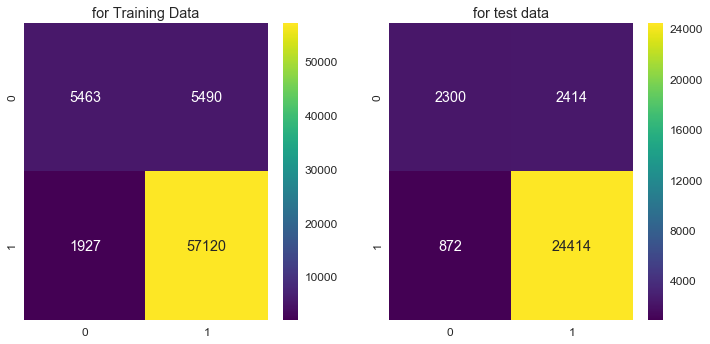

In [97]:
sns.set(font_scale = 1.2)
plt.figure(figsize = (12,12))#setting the font size
plt.subplot(2,2,1)
plt.title('for Training Data')
sns.heatmap(train_matrix,annot = True,fmt = 'g',cmap = 'viridis')#heatmap for training data confusion matrix 

plt.subplot(2,2,2)
plt.title('for test data')
sns.heatmap(test_matrix,annot = True,fmt = 'g',cmap = 'viridis')
#annot = True writes data values in each cell
# fmt is string formatting code which is to be used when adding annonations
# cmap is the mapping from data values to color space

In [0]:
print(w2v_words[:100])

['minute', 'web', 'search', 'ingredients', 'thai', 'pavilion', 'garlic', 'basil', 'stir', 'fry', 'rice', 'noodles', 'sauce', 'boxes', 'pack', 'noodle', 'flour', 'water', 'salt', 'fresh', 'green', 'chilies', 'soy', 'oil', 'oyster', 'cane', 'sugar', 'extract', 'cornstarch', 'fish', 'anchovies', 'vinegar', 'soybeans', 'tried', 'brand', 'europe', 'great', 'taste', 'fast', 'prep', 'see', 'amazon', 'com', 'like', 'dumplings', 'really', 'come', 'veg', 'biryani', 'think', 'best', 'gluten', 'free', 'enjoyed', 'shampoo', 'small', 'amount', 'needed', 'later', 'entire', 'scalp', 'clean', 'scent', 'helps', 'control', 'dandruff', 'buy', 'product', 'highly', 'recommended', 'first', 'time', 'trying', 'good', 'even', 'better', 'ca', 'not', 'wait', 'try', 'flavors', 'enjoy', 'cup', 'coffee', 'use', 'keurig', 'maker', 'want', 'timothys', 'extra', 'bold', 'rain', 'forest', 'blend', 'find', 'strong', 'satisfying', 'looking', 'box', 'raisins']


## Most important features

In [98]:
clf_optimal = LogisticRegression(C =best_C_tfidf_l1,penalty='l2')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
w = clf_optimal.coef_[0]#finding the coefficients of all features
print(w)



features = vect.get_feature_names()#getting name of the features after fitting and transforming by countvectorizer

#sorting the indexes with respect to values
negative_indices = np.argsort(w)

#reversing the sorted indexes with respect to values for positive indexes
positive_indices = np.argsort(w)[::-1]


print('TOP 20 important features for positive class and their coefficients in Average word to vector featurization using l2 regularization are:\n')
for i in (positive_indices[0:20]):
    print("%s\t --> \t%f"%(features[i],w[i]))
print("************************************************")

print('TOP 20 important features for negative class and their coefficients in Average word to vector featurization using l2 regularization are:\n')
for i in (negative_indices[0:20]):
    print("{} ---> {} ".format(features[i],w[i]))



[ 0.33249754  0.22632542 -0.11215931 -0.14471572 -0.76657402  0.27410818
 -0.11775058  0.0120791   0.4687459  -0.52505134 -0.36869766  0.42565835
 -0.09548264  0.0258813   0.11040013  0.43214333  0.49404847  0.0463633
  0.39781691  0.29969006  0.07687872 -0.00619184  0.04651214  0.61701018
  0.24660535  0.08215599 -0.23136951 -0.23757829  0.42828935  0.20632952
 -0.18762274 -0.39311051 -0.06194791  0.04577286  0.09209197  0.02429106
 -0.3676515  -0.18372266 -0.10693906  0.27838581  0.14299725 -0.13471574
 -0.35477956 -0.1462672   0.25105813  0.11204479 -0.04418194 -0.07870766
 -0.29235997  0.26600071]
TOP 20 important features for positive class and their coefficients in Average word to vector featurization using l2 regularization are:

able purchase	 --> 	0.617010
able give	 --> 	0.494048
able chew	 --> 	0.468746
able get	 --> 	0.432143
able stop	 --> 	0.428289
able enjoy	 --> 	0.425658
able keep	 --> 	0.397817
aa	 --> 	0.332498
able locate	 --> 	0.299690
absolute best	 --> 	0.278386


## L1 regularization


In [99]:
param = {'C': [10**i for i in range(-4,5)]}#fixing the size and range of parameters to  be searched

model = GridSearchCV(LogisticRegression(penalty='l1'),param_grid = param,scoring = 'roc_auc',n_jobs=-1)#l1 regularization
#using the grid search cross validation
model.fit(train_std,Y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [104]:
train_auc = model.cv_results_['mean_train_score']#deriving the avg training scores
cv_auc = model.cv_results_['mean_test_score']#deriving the average cross validation scores

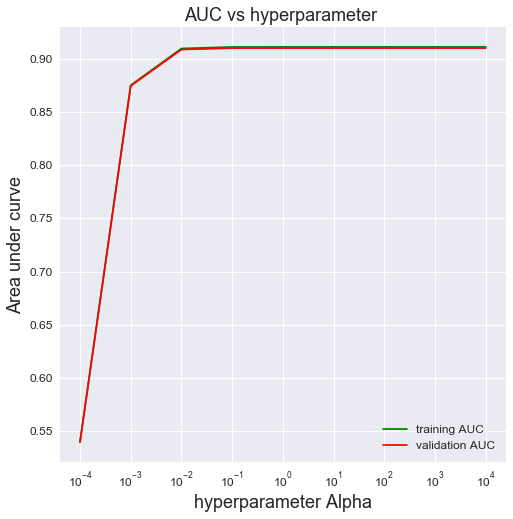

In [105]:
error(train_auc,cv_auc)

In [106]:
best_C_l1_aW2v = model.best_params_['C']
print(best_C_l1_aW2v)
#this gives us the best hyperparameter found after gridsearch cross validation


10000


best value of hyperparameter in this case is C = 10000

In [107]:
from sklearn.metrics import roc_auc_score
clf_optimal = LogisticRegression(C =best_C_l1_aW2v,penalty='l1')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
train_pred = clf_optimal.predict_proba(train_std)[:,1]
#predict_proba gives the probability of a data point belonging to a particular class

test_pred = clf_optimal.predict_proba(test_std)[:,1]
#this predicts the probability of data pointsin test dataset belonging to class '1'

test_auc_aW2v_l1 = roc_auc_score(Y_test,test_pred)
print('AUC on test dataset is {}'.format(test_auc_aW2v_l1))
#calculating the area under the curve for the roc curve that will be drawn on test dataset

AUC on test dataset is 0.9081588007819312


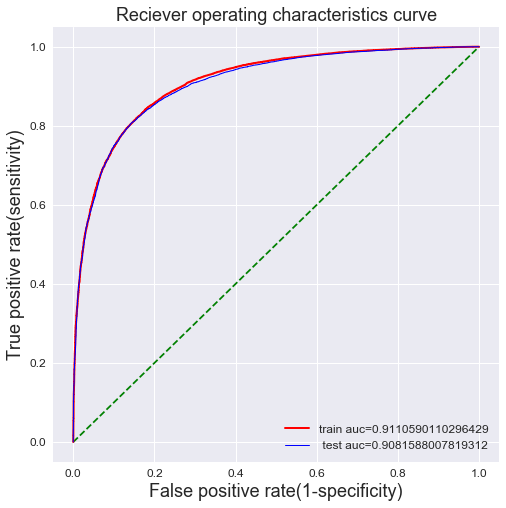

In [108]:
from sklearn.metrics import roc_curve

fpr_tr, tpr_tr, _ = roc_curve(Y_train,train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_pred)
#calculating the fpr,tpr and thresholds for each training and test dataset
auc_train = roc_auc_score(Y_train,train_pred)
auc_test = roc_auc_score(Y_test, test_pred)
#calculating the area under the curve for both test and train auc after fitting the model with optimal parameters
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()
   

In [110]:
pred = clf_optimal.predict(test_std)
# predicting all the classes for test dataset for confusion matrix

#predicting all classes for training dataset for confusion matrix
pred_tr = clf_optimal.predict(train_std)

# calculating the precison score
print('precison score is {}'.format(precision_score(Y_test,pred)))

#calculating the recall score 
print('\nrecall_score is {}'.format(recall_score(Y_test,pred)))

#calculating the f1 score
print('\nf1 score is {}'.format(f1_score(Y_test,pred)))

precison score is 0.909982108245117

recall_score is 0.9654749663845607

f1 score is 0.9369075488352459


In [111]:
train_matrix = pd.DataFrame(confusion_matrix(Y_train,pred_tr),range(2),range(2))# svaing the output to dataframe to visualize a heatmap
print(train_matrix.head())

test_matrix = pd.DataFrame(confusion_matrix(Y_test,pred),range(2),range(2))# svaing the output to dataframe to visualize a heatmap
print(test_matrix.head())

      0      1
0  5462   5491
1  1929  57118
      0      1
0  2299   2415
1   873  24413


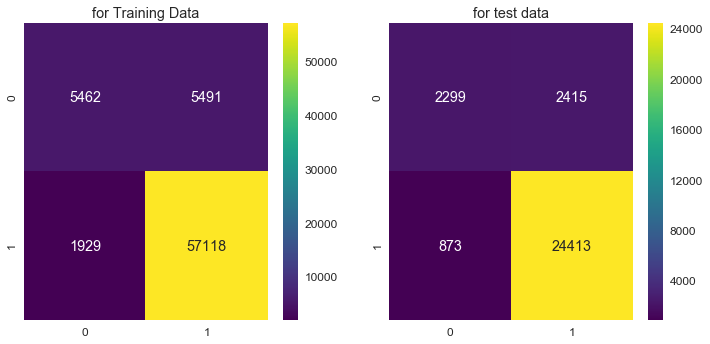

In [112]:
sns.set(font_scale = 1.2)
plt.figure(figsize = (12,12))#setting the font size
plt.subplot(2,2,1)
plt.title('for Training Data')
sns.heatmap(train_matrix,annot = True,fmt = 'g',cmap = 'viridis')#heatmap for training data confusion matrix 

plt.subplot(2,2,2)
plt.title('for test data')
sns.heatmap(test_matrix,annot = True,fmt = 'g',cmap = 'viridis')
#annot = True writes data values in each cell
# fmt is string formatting code which is to be used when adding annonations
# cmap is the mapping from data values to color space

## Most important features

In [113]:

clf_optimal = LogisticRegression(C =best_C_tfidf_l1,penalty='l1')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
w = clf_optimal.coef_[0]#finding the coefficients of all features
print(w)



features = vect.get_feature_names()#getting name of the features after fitting and transforming by countvectorizer

#sorting the indexes with respect to values
negative_indices = np.argsort(w)

#reversing the sorted indexes with respect to values for positive indexes
positive_indices = np.argsort(w)[::-1]


print('TOP 20 important features for positive class and their coefficients in Average word to vector featurization using l1 regularization are:\n')
for i in (positive_indices[0:20]):
    print("%s\t --> \t%f"%(features[i],w[i]))
print("************************************************")

print('TOP 20 important features for negative class and their coefficients in Average word to vector featurization using l1 regularization are:\n')
for i in (negative_indices[0:20]):
    print("{} ---> {} ".format(features[i],w[i]))




[ 0.35382672  0.21826192 -0.09171839 -0.19006324 -0.78747075  0.24180057
 -0.11645953  0.          0.40906789 -0.50564411 -0.37807871  0.35613184
 -0.03502464  0.          0.07459885  0.37811542  0.51484649  0.00242207
  0.33168279  0.2266303   0.07158286  0.          0.00110876  0.56314176
  0.23915444  0.06431136 -0.23115775 -0.21874359  0.4279942   0.15725564
 -0.17880117 -0.43995641 -0.06908447  0.          0.08510936  0.03358359
 -0.35345095 -0.12748578 -0.09758805  0.14332622  0.07475794 -0.07254902
 -0.33960735 -0.10160292  0.25422559  0.09110122  0.         -0.05736251
 -0.20925416  0.24517293]
TOP 20 important features for positive class and their coefficients in Average word to vector featurization using l1 regularization are:

able purchase	 --> 	0.563142
able give	 --> 	0.514846
able stop	 --> 	0.427994
able chew	 --> 	0.409068
able get	 --> 	0.378115
able enjoy	 --> 	0.356132
aa	 --> 	0.353827
able keep	 --> 	0.331683
absolutely awesome	 --> 	0.254226
absolutely fantastic	

## TFIDF weighted Word to vector

In [114]:
vect = TfidfVectorizer()#initializing the tfidf vectorizer 

tf_idf = vect.fit_transform(X_train)#fitting the training data
dictionary = dict(zip(vect.get_feature_names(), list(vect.idf_)))#zipping both of the feature names and vectorizer idf scores

In [115]:
import itertools
dict(itertools.islice(dictionary.items(),20))
#printing first 20 elements of the dictionary

{'aa': 9.758369533845372,
 'aaa': 10.210354657588429,
 'aaaaa': 11.057652517975633,
 'aaaaaaaaaaaaa': 11.463117626083797,
 'aaaaaaaaaaaaaaaaacccccccckkkkkk': 11.463117626083797,
 'aaaaaaahhhhhh': 11.463117626083797,
 'aaaaaah': 11.463117626083797,
 'aaaaaahhhhhyaaaaaa': 11.463117626083797,
 'aaaaaawwwwwwwwww': 11.463117626083797,
 'aaaah': 11.463117626083797,
 'aaaand': 11.463117626083797,
 'aaaannnnddd': 11.463117626083797,
 'aaaarrrrghh': 11.463117626083797,
 'aaah': 10.364505337415688,
 'aaahhh': 11.463117626083797,
 'aaahs': 11.463117626083797,
 'aabout': 11.463117626083797,
 'aabsolutely': 11.463117626083797,
 'aad': 11.463117626083797,
 'aadd': 11.463117626083797}

In [116]:
tfidf_feat = vect.get_feature_names() # tfidf words/col-names
print(tfidf_feat[:10])

['aa', 'aaa', 'aaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaacccccccckkkkkk', 'aaaaaaahhhhhh', 'aaaaaah', 'aaaaaahhhhhyaaaaaa', 'aaaaaawwwwwwwwww', 'aaaah']


In [117]:
train_set = []; # the tfidf-w2v for each sentence/review in training set is stored in this list
row=0;
for sent in tqdm(s_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_set.append(sent_vec)
    row += 1    
print(len(train_set))

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [1:03:47<00:00, 18.29it/s]


70000


In [118]:
test_set = []; # the tfidf-w2v for each sentence/review in test set is stored in this list
row=0;
for sent in s_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_set.append(sent_vec)
    row += 1
    
print(len(test_set))


30000


In [119]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
train_std = StandardScaler(with_mean = False).fit_transform(train_set)
test_std = StandardScaler(with_mean = False).fit_transform(test_set)
#with_mean cannot be True here because we are dealing with sparse matrices
print('after standardization: {}'.format(train_std.shape))
print("test data:",test_std.shape)

after standardization: (70000, 50)
test data: (30000, 50)


## L2 regularization

In [120]:
param = {'C': [10**i for i in range(-4,5)]}#fixing the size and range of parameters to  be searched

model = GridSearchCV(LogisticRegression(penalty='l2'),param_grid = param,scoring = 'roc_auc',n_jobs=-1)#using gridsearch cross validation
model.fit(train_std,Y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [121]:
best_C_l2_tiW2v = model.best_params_['C']
print(best_C_l2_tiW2v)
#this gives us the best hyperparameter found after gridsearch cross validation


10000


In [122]:
train_auc = model.cv_results_['mean_train_score']#deriving the avg training scores
cv_auc = model.cv_results_['mean_test_score']#deriving the average cross validation scores

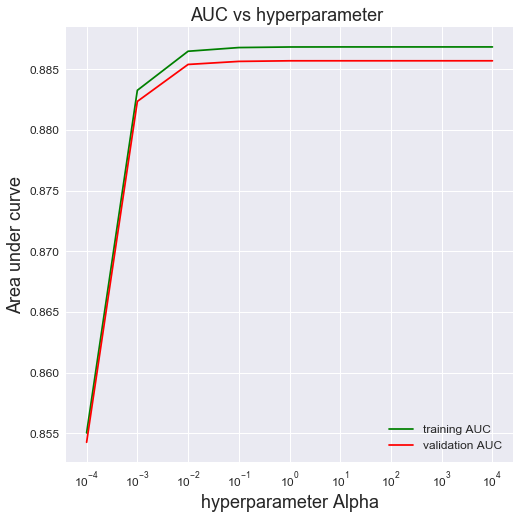

In [123]:
error(train_auc,cv_auc)

from AUC vs hyperparameter graph we can deduce that best C = 0.1

In [124]:
from sklearn.metrics import roc_auc_score
clf_optimal = LogisticRegression(C =0.1,penalty='l2')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
train_pred = clf_optimal.predict_proba(train_std)[:,1]
#predict_proba gives the probability of a data point belonging to a particular class

test_pred = clf_optimal.predict_proba(test_std)[:,1]
#this predicts the probability of data pointsin test dataset belonging to class '1'

test_auc_tiW2v_l2 = roc_auc_score(Y_test,test_pred)
print('AUC on test dataset is {}'.format(test_auc_tiW2v_l2))
#calculating the area under the curve for the roc curve that will be drawn on test dataset

AUC on test dataset is 0.8833959234822027


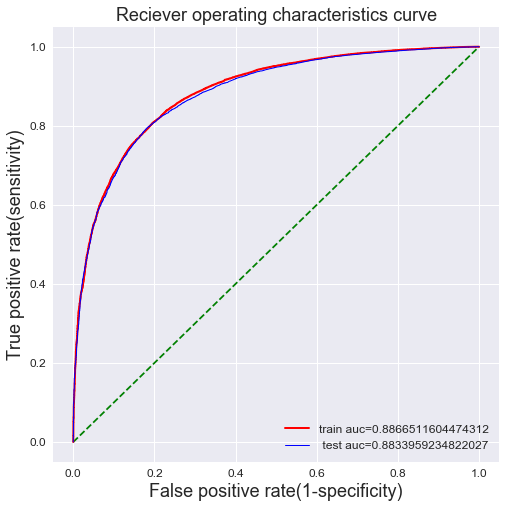

In [125]:
from sklearn.metrics import roc_curve

fpr_tr, tpr_tr, _ = roc_curve(Y_train,train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_pred)
#calculating the fpr,tpr and thresholds for each training and test dataset
auc_train = roc_auc_score(Y_train,train_pred)
auc_test = roc_auc_score(Y_test, test_pred)
#calculating the area under the curve for both test and train auc after fitting the model with optimal parameters
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()
   

In [126]:

pred = clf_optimal.predict(test_std)
# predicting all the classes for test dataset for confusion matrix

pred_tr = clf_optimal.predict(train_std)

# calculating the precison score
print('precison score is {}'.format(precision_score(Y_test,pred)))

#calculating the recall score 
print('\nrecall_score is {}'.format(recall_score(Y_test,pred)))

#calculating the f1 score
print('\nf1 score is {}'.format(f1_score(Y_test,pred)))

precison score is 0.8960629921259843

recall_score is 0.9676105354741754

f1 score is 0.9304633872715864


In [128]:
train_matrix = pd.DataFrame(confusion_matrix(Y_train,pred_tr),range(2),range(2))# svaing the output to dataframe to visualize a heatmap
print(train_matrix.head())

print("************************************8")
test_matrix = pd.DataFrame(confusion_matrix(Y_test,pred),range(2),range(2))# svaing the output to dataframe to visualize a heatmap
print(test_matrix.head())

      0      1
0  4453   6500
1  1883  57164
************************************8
      0      1
0  1876   2838
1   819  24467


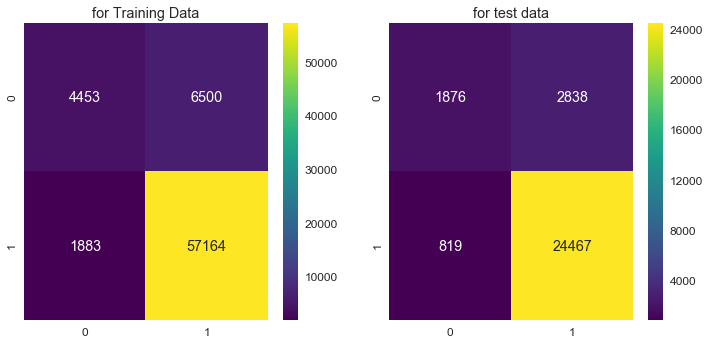

In [129]:
sns.set(font_scale = 1.2)
plt.figure(figsize = (12,12))#setting the font size
plt.subplot(2,2,1)
plt.title('for Training Data')
sns.heatmap(train_matrix,annot = True,fmt = 'g',cmap = 'viridis')#heatmap for training data confusion matrix 

plt.subplot(2,2,2)
plt.title('for test data')
sns.heatmap(test_matrix,annot = True,fmt = 'g',cmap = 'viridis')
#annot = True writes data values in each cell
# fmt is string formatting code which is to be used when adding annonations
# cmap is the mapping from data values to color space

## Most Important features

In [130]:
clf_optimal = LogisticRegression(C =best_C_tfidf_l1,penalty='l1')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
w = clf_optimal.coef_[0]#finding the coefficients of all features
print(w)



features = vect.get_feature_names()#getting name of the features after fitting and transforming by countvectorizer

#sorting the indexes with respect to values
negative_indices = np.argsort(w)

#reversing the sorted indexes with respect to values for positive indexes
positive_indices = np.argsort(w)[::-1]


print('TOP 20 important features for positive class and their coefficients in Average word to vector featurization using l1 regularization are:\n')
for i in (positive_indices[0:20]):
    print("%s\t --> \t%f"%(features[i],w[i]))
print("************************************************")

print('TOP 20 important features for negative class and their coefficients in Average word to vector featurization using l1 regularization are:\n')
for i in (negative_indices[0:20]):
    print("{} ---> {} ".format(features[i],w[i]))




[ 0.36702762  0.21112755 -0.21402329 -0.16841412 -0.7900127   0.21776977
 -0.15435853  0.06156578  0.35105977 -0.55207297 -0.32306572  0.29290369
 -0.00326769  0.05898802  0.08320246  0.29528588  0.4923211   0.10028571
  0.32091022  0.26609583  0.04687623  0.          0.          0.57716042
  0.24803919  0.06642202 -0.10572838 -0.27510947  0.39632504  0.11925251
 -0.16300473 -0.54614754 -0.04805879 -0.03736122  0.08323652  0.10955805
 -0.39206037 -0.06273327 -0.13264115  0.19853702  0.08254298 -0.10456749
 -0.38018459 -0.02508837  0.23397396  0.02805636  0.0087161  -0.00979268
 -0.0912951   0.33869285]
TOP 20 important features for positive class and their coefficients in Average word to vector featurization using l1 regularization are:

aafter	 --> 	0.577160
aabout	 --> 	0.492321
aaloo	 --> 	0.396325
aa	 --> 	0.367028
aaaaaawwwwwwwwww	 --> 	0.351060
abd	 --> 	0.338693
aad	 --> 	0.320910
aaahs	 --> 	0.295286
aaaannnnddd	 --> 	0.292904
aadd	 --> 	0.266096
aahhed	 --> 	0.248039
abbey	 --

## L1 regularization

In [131]:
param = {'C': [10**i for i in range(-4,5)]}#fixing the size and range of parameters to  be searched

model = GridSearchCV(LogisticRegression(penalty='l1'),param_grid = param,scoring = 'roc_auc',n_jobs=-1)#using l1 regularization
#and grid search cross validation
model.fit(train_std,Y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [132]:
best_C_l1_tiW2v = model.best_params_['C']
print(best_C_l1_tiW2v)
#this gives us the best hyperparameter found after gridsearch cross validation


10000


In [133]:
train_auc = model.cv_results_['mean_train_score']#deriving the avg training scores
cv_auc = model.cv_results_['mean_test_score']#deriving the average cross validation scores

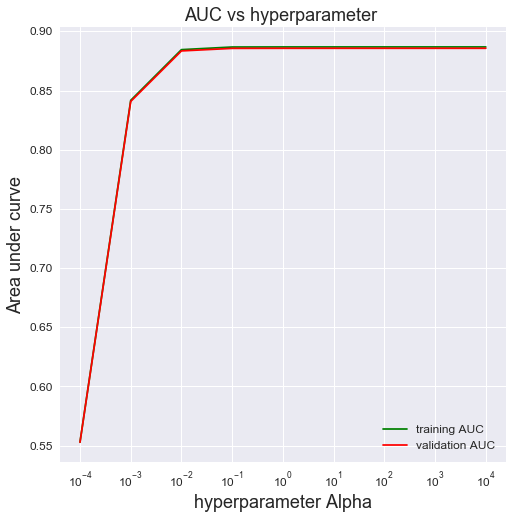

In [134]:
error(train_auc,cv_auc)

In [135]:
from sklearn.metrics import roc_auc_score
clf_optimal = LogisticRegression(C =10,penalty='l1')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
train_pred = clf_optimal.predict_proba(train_std)[:,1]
#predict_proba gives the probability of a data point belonging to a particular class

test_pred = clf_optimal.predict_proba(test_std)[:,1]
#this predicts the probability of data pointsin test dataset belonging to class '1'

test_auc_tiW2v_l2 = roc_auc_score(Y_test,test_pred)
print('AUC on test dataset is {}'.format(test_auc_tiW2v_l2))
#calculating the area under the curve for the roc curve that will be drawn on test dataset

AUC on test dataset is 0.8834286001490426


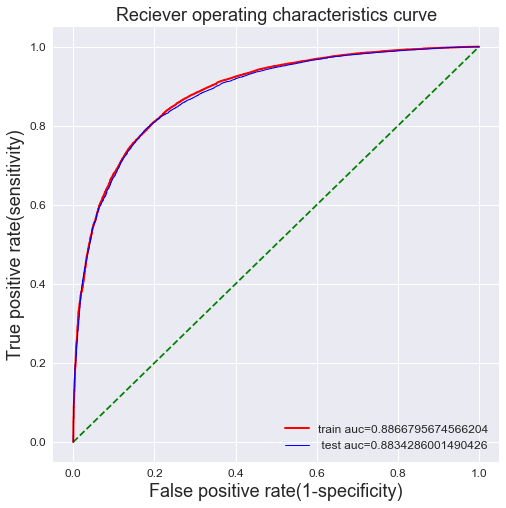

In [136]:
from sklearn.metrics import roc_curve

fpr_tr, tpr_tr, _ = roc_curve(Y_train,train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_pred)
#calculating the fpr,tpr and thresholds for each training and test dataset
auc_train = roc_auc_score(Y_train,train_pred)
auc_test = roc_auc_score(Y_test, test_pred)
#calculating the area under the curve for both test and train auc after fitting the model with optimal parameters
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()
   

In [159]:
pred = clf_optimal.predict(test_std)
# predicting all the classes for test dataset for confusion matrix

pred_tr = clf_optimal.predict(train_std)
# calculating the precison score
print('precison score is {}'.format(precision_score(Y_test,pred)))

#calculating the recall score 
print('\nrecall_score is {}'.format(recall_score(Y_test,pred)))

#calculating the f1 score
print('\nf1 score is {}'.format(f1_score(Y_test,pred)))

precison score is 0.9283585467989588

recall_score is 0.9731867436526142

f1 score is 0.9502442414998166


In [160]:
test_matrix = pd.DataFrame(confusion_matrix(Y_test,pred),range(2),range(2))# svaing the output to dataframe to visualize a heatmap
print(test_matrix.head())

print("*************************************")

train_matrix = pd.DataFrame(confusion_matrix(Y_train,pred_tr),range(2),range(2))# svaing the output to dataframe to visualize a heatmap
print(train_matrix.head())

      0      1
0  2815   1899
1   678  24608
*************************************
      0      1
0  9825   1128
1   174  58873


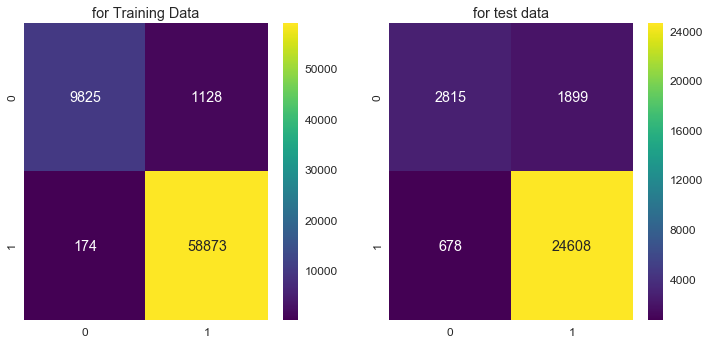

In [161]:
sns.set(font_scale = 1.2)
plt.figure(figsize = (12,12))#setting the font size
plt.subplot(2,2,1)
plt.title('for Training Data')
sns.heatmap(train_matrix,annot = True,fmt = 'g',cmap = 'viridis')#heatmap for training data confusion matrix 

plt.subplot(2,2,2)
plt.title('for test data')
sns.heatmap(test_matrix,annot = True,fmt = 'g',cmap = 'viridis')
#annot = True writes data values in each cell
# fmt is string formatting code which is to be used when adding annonations
# cmap is the mapping from data values to color space

## Most important features

In [162]:
clf_optimal = LogisticRegression(C =best_C_tfidf_l1,penalty='l1')#fitting the best hyperparameter found by tuning the model
clf_optimal.fit(train_std,Y_train)
w = clf_optimal.coef_[0]#finding the coefficients of all features
print(w)



features = vect.get_feature_names()#getting name of the features after fitting and transforming by countvectorizer

#sorting the indexes with respect to values
negative_indices = np.argsort(w)

#reversing the sorted indexes with respect to values for positive indexes
positive_indices = np.argsort(w)[::-1]


print('TOP 20 important features for positive class and their coefficients in Average word to vector featurization using l1 regularization are:\n')
for i in (positive_indices[0:20]):
    print("%s\t --> \t%f"%(features[i],w[i]))
print("************************************************")

print('TOP 20 important features for negative class and their coefficients in Average word to vector featurization using l1 regularization are:\n')
for i in (negative_indices[0:20]):
    print("{} ---> {} ".format(features[i],w[i]))




[0. 0. 0. ... 0. 0. 0.]
TOP 20 important features for positive class and their coefficients in Average word to vector featurization using l1 regularization are:

great	 --> 	0.664565
best	 --> 	0.478902
delicious	 --> 	0.407227
good	 --> 	0.390245
perfect	 --> 	0.353568
love	 --> 	0.338386
excellent	 --> 	0.324584
loves	 --> 	0.288892
highly	 --> 	0.257104
wonderful	 --> 	0.237511
nice	 --> 	0.225360
favorite	 --> 	0.215427
tasty	 --> 	0.207011
awesome	 --> 	0.201361
easy	 --> 	0.190536
happy	 --> 	0.184563
pleased	 --> 	0.165653
find	 --> 	0.156288
use	 --> 	0.149085
yummy	 --> 	0.146443
************************************************
TOP 20 important features for negative class and their coefficients in Average word to vector featurization using l1 regularization are:

not ---> -0.5192782548561297 
disappointed ---> -0.2311863606830064 
worst ---> -0.2093931061792437 
awful ---> -0.18987746868348684 
terrible ---> -0.16515559836251398 
disappointing ---> -0.16159938206340538 
money 

## Conclusion

In [163]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['featurization' , 'regularization' , 'best hyperparameter(C = 1/lambda)' , 'AUC on Test data']

#x.add_row(['Bag of words' , 'l2' ,best_C_l2_bow ,test_auc_bow_l2])
#x.add_row(['Bag of Words','l1',best_C_l1_bow,test_auc_bow_l1])
x.add_row(['TFIDF','l2',best_C_tfidf_l2,test_auc_tfidf_l2])
x.add_row(['TFIDF','l1',best_C_tfidf_l1,test_auc_tfidf_l1])
x.add_row(['Average W2V','l2',best_C_l2_aW2v,test_auc_aW2v_l2])
x.add_row(['Avergae W2V','l1',best_C_l1_aW2v,test_auc_aW2v_l1])
x.add_row(['tfidf W2V','l2',best_C_l2_tiW2v,test_auc_tiW2v_l2])
x.add_row(['tfidf W2V','l1',best_C_l1_tiW2v,test_auc_tiW2v_l2])






print(x)


+---------------+----------------+-----------------------------------+--------------------+
| featurization | regularization | best hyperparameter(C = 1/lambda) |  AUC on Test data  |
+---------------+----------------+-----------------------------------+--------------------+
|     TFIDF     |       l2       |               0.0001              | 0.954694837516176  |
|     TFIDF     |       l1       |                0.01               | 0.9609490424872511 |
|  Average W2V  |       l2       |                 10                | 0.9081629703078412 |
|  Avergae W2V  |       l1       |               10000               | 0.9081588007819312 |
|   tfidf W2V   |       l2       |               10000               | 0.8834286001490426 |
|   tfidf W2V   |       l1       |               10000               | 0.8834286001490426 |
+---------------+----------------+-----------------------------------+--------------------+


1. We observe that best AUC score is given by TFIDF vectorizer using l1 regularization.
2. L1 regularization is computationally expensive due to the optimised solution creating sparsity 
3. Using Pertubation Testing as a hack of checking multicollinearity,we obseved that due to very small percentage of features changing their weight vectors by huge margin
